---
title: "QuantLib: Curva de Cupom Cambial"
description: |
    Como construir as curvas de cupom cambial, limpo e sujo, usando QuantLib com Python.
author:
  - name: Wilson Freitas
    url: {}
date: 2023-08-01
categories:
  - python
  - quantlib
  - brasa
  - B3
---

Vamos construir as curvas de cupom cambial, limpo e sujo, da B3 utilizando a biblioteca QuantLib.

Primeiramente vou fazer o *setup* do projeto `brasa` definindo o repositório que contém os dados.
Lembrando que o projeto `brasa` é um projeto em release *alpha* que venho trabalhando para organizar dados de fontes
públicas.

In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"
import brasa

Os demais pacotes importados são o *setup* básico que inclui: `pandas`, `numpy`, `datetime`, `matplotlib` e `pyarrow`.

In [2]:
from datetime import datetime

import QuantLib as ql
import pandas as pd
import numpy as np
import pyarrow.compute as pc
import matplotlib.ticker as mticker

Vou trabalhar com a data de referência 2023-07-14.
Para esta data vamos começar carregando os contratos futuros de dólar (DOL) e taxa DI (DI1) negociados na B3.
Utilizo o pacote `brasa` para obter os dados de preços de ajuste dos contratos futuros da B3.

In [3]:
refdate = datetime(2023, 7, 14)

fut_dol = (brasa
         .get_dataset("b3-futures-dol")
         .filter(pc.field("refdate") == refdate)
         .to_table()
         .to_pandas())

fut_di1 = (brasa
         .get_dataset("b3-futures-di1")
         .filter(pc.field("refdate") == refdate)
         .to_table()
         .to_pandas())

Agora vamos pegar a taxa DI para a data de referência utilizando o *dataset* de indicadores econômicos divulgado pela B3.
Isso é importante porque estes dados são utilizados pela B3 na construção das curvas.

In [4]:
cdi = (brasa
    .get_dataset("b3-economic-indicators-price")
    .filter(pc.field("refdate") == refdate)
    .filter(pc.field("commodity") == "DI1")
    .filter(pc.field("symbol") == "RTDI1")
    .to_table(columns=["price"])
    .to_pandas().iloc[0,0]) / 100

Preciso ainda obter as cotações de dólar, e acredite, temos diversas cotações de dólar.
As cotações de dólar são referentes à data de referência e ao dia anterior.
Para obter estes pontos de forma higiênica, vou fazer o *setup* da QuantLib e utilizar o calendário brasileiro para
filtrar os dados nas datas de interesse, a data de referência e o dia anterior.

In [5]:
today = ql.Date().from_date(refdate)
ql.Settings.instance().evaluationDate = today
calendar = ql.Brazil(ql.Brazil.Settlement)
calendar_act = ql.NullCalendar()

In [6]:
df_econ_ind = (brasa
    .get_dataset("b3-economic-indicators-price")
    .filter(pc.field("refdate") >= calendar.advance(today, ql.Period(-1, ql.Days)).to_date())
    .filter(pc.field("refdate") <= refdate)
    .filter(pc.field("commodity") == "DOL")
    .to_table()
    .to_pandas())
df_econ_ind

,refdate,commodity,symbol,description,price
0,2023-07-13,DOL,RTDOLCL,DÓLAR CUPOM LIMPO - CÁLCULADO PELA B3,4.7922
1,2023-07-13,DOL,RTDOLD1,DÓLAR B3 SPOT - 1 DIA,4.7949
2,2023-07-13,DOL,RTDOLD2,DÓLAR B3 SPOT - 2 DIAS,4.7967
3,2023-07-13,DOL,RTDOLT1,PTAX800 VENDA,4.8038
4,2023-07-14,DOL,RTDOLCL,DÓLAR CUPOM LIMPO - CÁLCULADO PELA B3,4.7896
5,2023-07-14,DOL,RTDOLD1,DÓLAR B3 SPOT - 1 DIA,4.7901
6,2023-07-14,DOL,RTDOLD2,DÓLAR B3 SPOT - 2 DIAS,4.7905
7,2023-07-14,DOL,RTDOLT1,PTAX800 VENDA,4.7957


Como podemos observar, para cada data de referência temos 4 cotações de dólar:

- Dólar cupom limpo cálculado pela B3 a partir do casado
- Dólar spot para liquidação em D+1
- Dólar spot para liquidação em D+2
- PTAX800 cotação de venda

Precisamos pegar a cotação da PTAX800 (apenas PTAX) do dia anterior para calcular o cupom sujo.

In [7]:
fut = fut_dol.merge(fut_di1, on=["refdate", "maturity_date", "business_days"], suffixes=("_dol", "_di1"))

In [8]:
refdate_1 = datetime(2023, 7, 13)
ptax_1 = df_econ_ind.loc[(df_econ_ind["refdate"] == refdate_1) & (df_econ_ind["symbol"] == "RTDOLT1"), "price"].item()
di1_factor = 100000 / fut["settlement_price_di1"]
dol_factor = fut["settlement_price_dol"] / (ptax_1 * 1000)

In [9]:
fixing = [calendar.advance(d, 1, ql.Days)
          for d in [calendar.adjust(ql.Date.from_date(d), ql.Following)
                    for d in fut["maturity_date"]]]
dc = [calendar_act.businessDaysBetween(today, d) for d in fixing]
fut["fixing"] = [datetime.fromordinal(d.to_date().toordinal()) for d in fixing]
fut["cupom_sujo"] = (di1_factor / dol_factor - 1) * 360 / dc

In [10]:
spot = df_econ_ind.loc[(df_econ_ind["refdate"] == refdate) & (df_econ_ind["symbol"] == "RTDOLCL"), "price"].item()
di1_factor = (100000 / fut["settlement_price_di1"]) / ((1 + cdi) ** (1/252))
dol_factor = fut["settlement_price_dol"] / (spot * 1000)

In [11]:
dc = [calendar_act.businessDaysBetween(calendar.advance(today, 2, ql.Days), ql.Date.from_date(d)) for d in fut["fixing"]]
fut["cupom_limpo"] = (di1_factor / dol_factor - 1) * 360 / dc
fut["dc_limpo"] = dc

In [12]:
us_curve = pd.concat(
    [pd.Series([1, 2, 3, 4, 6, 12, 24, 36, 60, 72, 120, 240, 360]) * 30,
    pd.Series([5.37,5.49,5.49,5.53,5.52,5.34,4.74,4.35,4.04,3.94,3.83,4.11,3.93]) / 100],
    axis=1
)

us_curve.columns = ["dc", "rate"]

In [13]:
us_curve["date"] = [datetime.fromordinal(calendar_act.advance(today, d, ql.Days).to_date().toordinal()) for d in us_curve["dc"]]

<Axes: xlabel='date'>

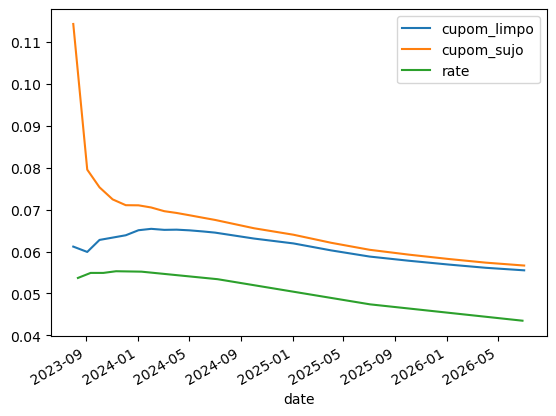

In [14]:
ax = fut[["fixing", "cupom_limpo", "cupom_sujo"]].set_index("fixing").plot()
us_curve[["date", "rate"]].query("date <= '2027-01-01'").set_index("date").plot(ax=ax)

### ZeroCurves



In [15]:
fut

,refdate,symbol_dol,maturity_date,settlement_price_dol,business_days,symbol_di1,settlement_price_di1,adjusted_tax,fixing,cupom_sujo,cupom_limpo,dc_limpo
0,2023-07-14,DOLQ23,2023-08-01,4804.178,12,DI1Q23,99392.59,0.136491,2023-08-02,0.114292,0.061177,15
1,2023-07-14,DOLU23,2023-09-01,4833.290,35,DI1U23,98260.92,0.134640,2023-09-04,0.079540,0.059905,48
2,2023-07-14,DOLV23,2023-10-01,4854.760,55,DI1V23,97301.37,0.133540,2023-10-03,0.075319,0.062771,77
3,2023-07-14,DOLX23,2023-11-01,4877.237,76,DI1X23,96323.37,0.132250,2023-11-03,0.072443,0.063326,108
4,2023-07-14,DOLZ23,2023-12-01,4895.157,96,DI1Z23,95439.88,0.130340,2023-12-04,0.071057,0.063883,139
5,2023-07-14,DOLF24,2024-01-01,4910.970,116,DI1F24,94589.18,0.128450,2024-01-03,0.071027,0.065082,169
6,2023-07-14,DOLG24,2024-02-01,4931.854,138,DI1G24,93678.83,0.126640,2024-02-02,0.070511,0.065416,199
7,2023-07-14,DOLH24,2024-03-01,4945.625,157,DI1H24,92926.76,0.124960,2024-03-04,0.069626,0.065172,230
8,2023-07-14,DOLJ24,2024-04-01,4961.281,177,DI1J24,92166.00,0.123160,2024-04-02,0.069206,0.065219,259
9,2023-07-14,DOLK24,2024-05-01,4978.755,199,DI1K24,91364.04,0.121170,2024-05-03,0.068646,0.065054,290


In [16]:
data = [(ql.Date.from_date(d), r) for d, r in zip(fut["fixing"], fut["cupom_limpo"])]
data.insert(0, (today, data[0][1]))
dates, yields = zip(*data)

In [17]:
dates

(Date(14,7,2023),
 Date(2,8,2023),
 Date(4,9,2023),
 Date(3,10,2023),
 Date(3,11,2023),
 Date(4,12,2023),
 Date(3,1,2024),
 Date(2,2,2024),
 Date(4,3,2024),
 Date(2,4,2024),
 Date(3,5,2024),
 Date(4,6,2024),
 Date(2,7,2024),
 Date(2,10,2024),
 Date(3,1,2025),
 Date(2,4,2025),
 Date(2,7,2025),
 Date(2,10,2025),
 Date(5,1,2026),
 Date(2,4,2026),
 Date(2,7,2026))

In [18]:
fut

,refdate,symbol_dol,maturity_date,settlement_price_dol,business_days,symbol_di1,settlement_price_di1,adjusted_tax,fixing,cupom_sujo,cupom_limpo,dc_limpo
0,2023-07-14,DOLQ23,2023-08-01,4804.178,12,DI1Q23,99392.59,0.136491,2023-08-02,0.114292,0.061177,15
1,2023-07-14,DOLU23,2023-09-01,4833.290,35,DI1U23,98260.92,0.134640,2023-09-04,0.079540,0.059905,48
2,2023-07-14,DOLV23,2023-10-01,4854.760,55,DI1V23,97301.37,0.133540,2023-10-03,0.075319,0.062771,77
3,2023-07-14,DOLX23,2023-11-01,4877.237,76,DI1X23,96323.37,0.132250,2023-11-03,0.072443,0.063326,108
4,2023-07-14,DOLZ23,2023-12-01,4895.157,96,DI1Z23,95439.88,0.130340,2023-12-04,0.071057,0.063883,139
5,2023-07-14,DOLF24,2024-01-01,4910.970,116,DI1F24,94589.18,0.128450,2024-01-03,0.071027,0.065082,169
6,2023-07-14,DOLG24,2024-02-01,4931.854,138,DI1G24,93678.83,0.126640,2024-02-02,0.070511,0.065416,199
7,2023-07-14,DOLH24,2024-03-01,4945.625,157,DI1H24,92926.76,0.124960,2024-03-04,0.069626,0.065172,230
8,2023-07-14,DOLJ24,2024-04-01,4961.281,177,DI1J24,92166.00,0.123160,2024-04-02,0.069206,0.065219,259
9,2023-07-14,DOLK24,2024-05-01,4978.755,199,DI1K24,91364.04,0.121170,2024-05-03,0.068646,0.065054,290


In [30]:
zc = ql.ZeroCurve(dates, yields, ql.Actual360(), calendar_act, ql.Linear(), ql.Simple, ql.Annual)

In [27]:
zc.referenceDate()

Date(14,7,2023)

In [34]:
zc.nodes()[:5]

((Date(14,7,2023), 0.06117228779556639),
 (Date(2,8,2023), 0.06107886119703954),
 (Date(4,9,2023), 0.059646910354024765),
 (Date(3,10,2023), 0.062331436428483024),
 (Date(3,11,2023), 0.06270993624705179))

In [32]:
days = calendar_act.businessDaysBetween(today, ql.Date(1,9,2023))
print(zc.zeroRate(days/360, ql.Simple))
print(zc.zeroRate(ql.Date(1,9,2023), ql.Actual360(), ql.Simple))

6.002093 % Actual/360 simple compounding
6.002093 % Actual/360 simple compounding


In [52]:
def plot_curve(crv):
    nodes = crv.nodes()
    today = crv.referenceDate()
    days = [calendar_act.businessDaysBetween(today, d) for d,r in nodes]
    i_curve = pd.DataFrame({
        "days": list(range(1, max(days))),
        "rates": [crv.zeroRate(i/360, ql.Simple).rate() for i in range(1, max(days))],
    })
    f_curve = pd.DataFrame({
        "days": list(range(1, max(days))),
        "rates": [crv.forwardRate(i/360, (i+1)/360, ql.Simple).rate() for i in list(range(1, max(days)))],
    })
    points = pd.DataFrame({
        "days": days,
        "rates": [r for d,r in nodes]
    })

    ax = points.plot.scatter(x="days", y="rates", figsize=(12, 6), label="Pontos da curva")
    i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
    f_curve.plot(x="days", y="rates", c="green", alpha=0.75, ax=ax, label="Forward 1D")
    ax.set_xlabel("Dias Corridos")
    ax.set_ylabel("Taxa (%)")
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));

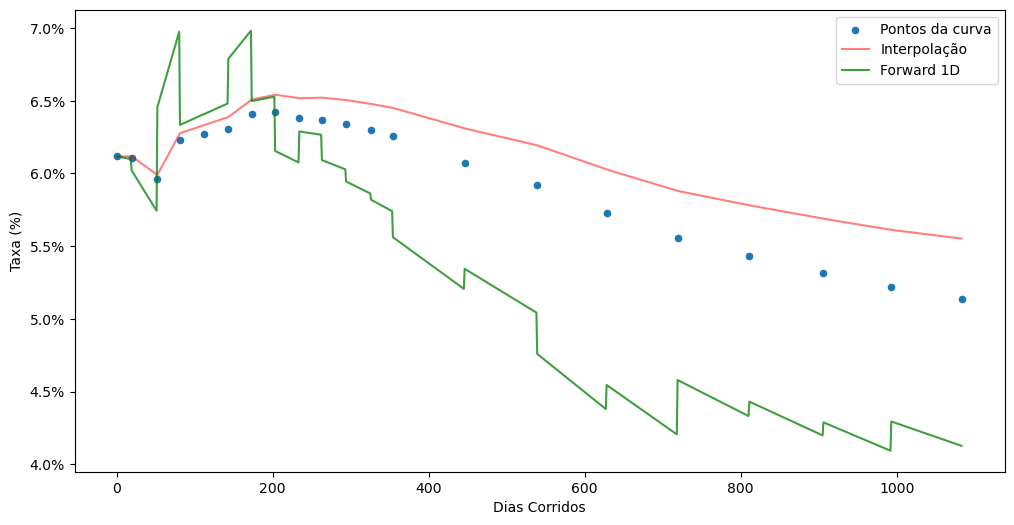

In [53]:
plot_curve(zc)